# Interpretable Machine Learning using Shap values

SHAP values are useful to address the problem of interpretability: the logistic regression model can yield a high accuracy, but it does not explain the effect of specific features had on the model. 

## Load the data

In [107]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [73]:
# Load the training data set
df_train = pd.read_csv('./train.csv', header=0)
df_test = pd.read_csv('./test.csv', header=0)

print(df_train.shape)
print(df_test.shape)

(641, 46)
(331, 46)


In [74]:
df_train.head(3)

,IDRSSD,date,Financial Institution Name,Institution Name,total_assets,defaulter,Failure / Assistance,log_TA,NI_to_TA,Equity_to_TA,...,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,default_within_1Y,Failure,max_total_assets,num_records,non_defaulter,const
0,904957,2008-03-31,COLORADO NATIONAL BANK,COLORADO NATIONAL BANK,142138.0,1.0,FAILURE,-0.048734,-6.505183,-0.759562,...,0.004823,-0.367905,-0.840312,-0.582232,1.0,1.0,142138.0,31.0,0.0,1
1,202907,2011-06-30,"COMMUNITY BANK, NATIONAL ASSOCIATION",NaN,6364903.0,0.0,NaN,2.754852,0.143005,0.249275,...,-0.003057,0.205816,-0.140365,0.003962,0.0,NaN,8494486.0,60.0,1.0,1
2,652874,2012-12-31,"NEXBANK, SSB",NaN,784781.0,0.0,NaN,1.211269,0.229021,-0.301031,...,-0.003506,0.470935,-0.799310,0.284815,0.0,NaN,2698563.0,60.0,1.0,1


In [75]:
fin_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 'ALLL_to_TL', 'core_deposits_to_TA', 
            'brokered_deposits_to_TA', 'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

## Logistic Regression

In [76]:
target = "defaulter"

# based on Feature selection on the notebook "BankDefault_FeatureSelection_LogRegression"
my_features = fin_cols[:6]
my_features

['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 'ALLL_to_TL']

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train = df_train[my_features]
y_train = df_train[target]
X_test = df_test[my_features]
y_test = df_test[target]

#model = sm.Logit(y_train, X_train).fit()
lr_model = LogisticRegression(random_state=0, C=10, multi_class='ovr', solver='newton-cg').fit(X_train, y_train)
lr_model

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [78]:
# get prediction
y_pred = lr_model.predict(X_test)

## SHAP analysis

The collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable (global interpretability). The following summary plot shows:

1. Variables are ranked in descending order. For example, log_TA is the most important and it is associated with a higher prediction.
2. Each dot represents an observation. The color shows whether that variable is high (in red) or low (in blue) for that observation.

Based on the later, **_Log_TA_ is negatively correlated to bank failure: it has a high (red), negative (left side of the axis) impact. _NPL_to_TL_ is positively correlated to bank failure: it has a high (red), positive (right side of the axis) impact.**

[SHAP documentation.](https://shap.readthedocs.io/en/latest/examples.html)

### Summary plot

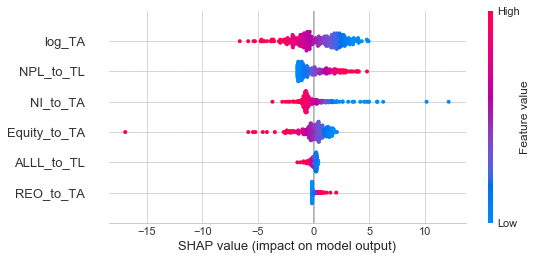

In [79]:
import shap  
shap.initjs()

explainer = shap.LinearExplainer(lr_model,X_train) 
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Individual predictions

In [80]:
def shap_plot(row_to_show):
    data_for_prediction = X_test.iloc[row_to_show]
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
    print('Actual Y: ',y_test[row_to_show])
    print('Predicted Y: ',y_pred[row_to_show])
    # Create object that can calculate shap values
    explainer = shap.LinearExplainer(lr_model, X_train) 
    # Calculate SHAP values
    shap_values = explainer.shap_values(data_for_prediction)
    #shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [81]:
shap_plot(1)

Actual Y:  0.0
Predicted Y:  0.0


In [82]:
shap_plot(5)

Actual Y:  1.0
Predicted Y:  1.0


## Random Forest

In [87]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

X_train = df_train[my_features]
y_train = df_train[target]
X_test = df_test[my_features]
y_test = df_test[target]

rf_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10).fit(X_train,y_train)
rf_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [88]:
# Get prediction
y_pred = rf_model.predict(X_test)

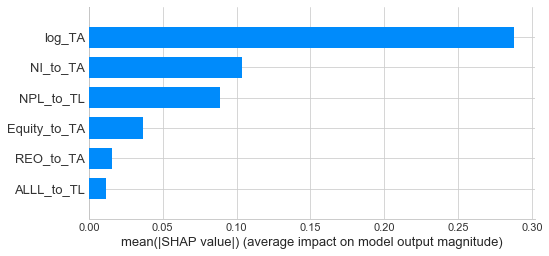

In [89]:
import shap  
shap.initjs()

explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Dependence plots

The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact that the slope goes up says that higher the value of NPL_to_TL, the higher the model's prediction is for **bank default**. The spread suggests that other features must interact with NPL_to_TL. Also, the higher the value of NPL_to_TL, the lower log_TA.

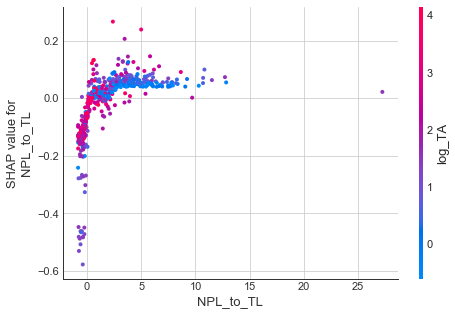

In [90]:
shap.dependence_plot("NPL_to_TL", shap_values, X_train, interaction_index="log_TA")

The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. 
By contrast, this slope is constant: a higher the value of REO_to_TA does not increase the model's prediction for bank default.

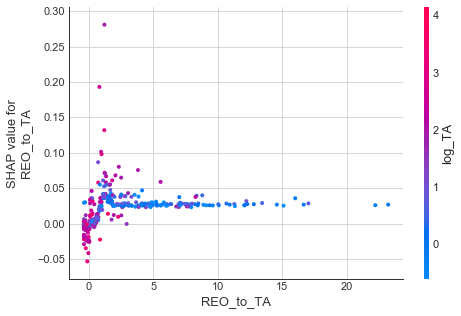

In [91]:
shap.dependence_plot("REO_to_TA", shap_values, X_train, interaction_index="log_TA")

### Individual predictions

In [92]:
def shap_plot(row_to_show):
    data_for_prediction = X_test.iloc[row_to_show]
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
    print('Actual Y: ',y_test[row_to_show])
    print('Predicted Y: ',y_pred[row_to_show])
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(rf_model) 
    # Calculate SHAP values
    shap_values = explainer.shap_values(data_for_prediction)
    #shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [93]:
shap_plot(1)

Actual Y:  0.0
Predicted Y:  0.010125448028673835


In [94]:
shap_plot(5)

Actual Y:  1.0
Predicted Y:  1.0


## XGBoost

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale.

In [108]:
import xgboost

X_train = df_train[my_features]
y_train = df_train[target]
X_test = df_test[my_features]
y_test = df_test[target]
xg_model = xgboost.XGBClassifier(max_depth=2).fit(X_train, y_train)


# compute SHAP values
explainer = shap.Explainer(xg_model, X_train)
shap_values = explainer(X_test)

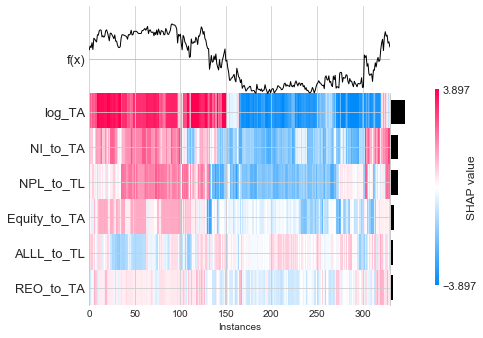

In [109]:
shap.plots.heatmap(shap_values)